# Homework #2 - Geospatial Analysis

---

#### EDS 296 - A Climate Modeling Perspective on "Big Data" Techniques

Marina Kochuten, Spring 2025

GitHub Repository: https://github.com/marinakochuten/geospatial-analysis-eds296-hw2

## Setup

In [1]:
# Import libraries
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import intake

ERROR 1: PROJ: proj_create_from_database: Open of /opt/anaconda3/envs/eds296-stevenson/share/proj failed


## Model Choice & Data Access

I am using the models CMCC-ESM2, the second generation CMCC Earth System Model which models Earth's climate and biosphere, integrating physical and biogeochemical processes, and CanESM5, the Canadian Earth System Model version 5, a global model developed to simulate historical climate change and variability. I will be using both historic and future scenarios. For the future scenarios, I will be using SSP585, the worst case outcome in terms of warming. 

Let's access the information of these models and scenario from the CMIP6 database hosted on Amazon Web Services:

In [2]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')


##### Search through catalog and store results #####
# CMCC Historic
res_cmcc_hist = catalog.search(
    activity_id = 'CMIP',
    source_id = 'CMCC-ESM2',
    experiment_id = 'historical',
    member_id = 'r1i1p1f1',
    table_id = 'Amon',
    variable_id = 'tas'
)

# CMCC SSP585
res_cmcc_fut = catalog.search(
    activity_id = 'ScenarioMIP',
    source_id = 'CMCC-ESM2',
    experiment_id = 'ssp585',
    member_id = 'r1i1p1f1',
    table_id = 'Amon',
    variable_id = 'tas'
)

# CanESM5 Historic
res_can_hist = catalog.search(
    activity_id = 'CMIP',
    source_id = 'CanESM5',
    experiment_id = 'historical',
    member_id = 'r1i1p1f1',
    table_id = 'Amon',
    variable_id = 'tas'
)

# CanESM5 SSP585
res_can_fut = catalog.search(
    activity_id = 'ScenarioMIP',
    source_id = 'CanESM5',
    experiment_id = 'ssp585',
    member_id = 'r1i1p1f1',
    table_id = 'Amon',
    variable_id = 'tas'
)

# Look at the results
display(res_cmcc_hist.df)
display(res_cmcc_fut.df)
display(res_can_hist.df)
display(res_can_fut.df)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CMCC,CMCC-ESM2,historical,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/CMCC/CMCC-ESM2/histo...,NaN,20210114


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,ScenarioMIP,CMCC,CMCC-ESM2,ssp585,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CMCC/CMCC-ESM...,NaN,20210126


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CCCma,CanESM5,historical,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/CCCma/CanESM5/histor...,NaN,20190429


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,ScenarioMIP,CCCma,CanESM5,ssp585,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429


In [3]:
# Grab results and save as xarray objects
cmcc_hist = xr.open_zarr(res_cmcc_hist.df.iloc[0]['zstore'], storage_options={'anon': True}, consolidated=True)
cmcc_fut = xr.open_zarr(res_cmcc_fut.df.iloc[0]['zstore'], storage_options={'anon': True}, consolidated=True)
can_hist = xr.open_zarr(res_can_hist.df.iloc[0]['zstore'], storage_options={'anon': True}, consolidated=True)
can_fut = xr.open_zarr(res_can_fut.df.iloc[0]['zstore'], storage_options={'anon': True}, consolidated=True)

In [4]:
# Concat historic and future data for cmcc model
cmcc_data = xr.concat([cmcc_hist, cmcc_fut], dim="time")

# Concat historic and future data for can model
can_data = xr.concat([can_hist, can_fut], dim="time")

## Region & Time Span

I am going to be looking at North America. This is a massive region with large variation in climate, including:
- The Arctic Circle where we are seeing incredibly rapid warming
- Temperate zones in southern Canada and Northern US which are experiencing heatwaves, increased drought risk, and wildfire
- Desert regions in southwestern US and Mexico also experiencing worstened drought and wildfire
- Subtropical and tropical regions in southeastern US and Central America, facing stronger and more frequent storms and sea level rise

I will be mapping surface air temperature over a 100 year period, showing historic temps from 1975-2025 and future projections for 2026-2075, centering the time span around where we are today.

## Map Average Over Each Time Period

First I need to define my area and time periods of interest 

In [5]:
# Array with region of interest
# [lon_min, lon_max, lat_min, lat_max]
region = [190, 345, 7, 85]

# Array with time periods of interest
# [starting year, ending year]
per_early = [1975, 2025]
per_late = [2026, 2075]

# Convert time to datetime 
cmcc_data['time'] = cmcc_data.time.astype('datetime64[ns]')
can_data['time'] = can_data.time.astype('datetime64[ns]')

# Sort by time to fix time filtering error
cmcc_data = cmcc_data.sortby('time')
can_data = can_data.sortby('time')

Next, I filter the data to this time

In [6]:
# Select data within the ranges of years specified above

##### CMCC-ESM2 #####
# Early period
cmcc_early = cmcc_data.sel(time=slice(str(per_early[0])+"-01-01", str(per_early[1])+"-12-31"))
# Late period
cmcc_late = cmcc_data.sel(time=slice(str(per_late[0])+"-01-01", str(per_late[1])+"-12-31"))

##### CanESM5 #####
# Early period
can_early = can_data.sel(time=slice(str(per_early[0])+"-01-01", str(per_early[1])+"-12-31"))
# Late period
can_late = can_data.sel(time=slice(str(per_late[0])+"-01-01", str(per_late[1])+"-12-31"))

Now, I can take averages and convert to celsius

In [7]:
# Calculate time averages and convert

##### CMCC-ESM2 #####
cmcc_early_annmn = cmcc_early.mean(dim="time") - 273.15
cmcc_late_annmn = cmcc_late.mean(dim="time") - 273.15

##### CanESM5 #####
can_early_annmn = can_early.mean(dim="time") - 273.15
can_late_annmn = can_late.mean(dim="time") - 273.15

Finally, we can map the average of each time period for both models

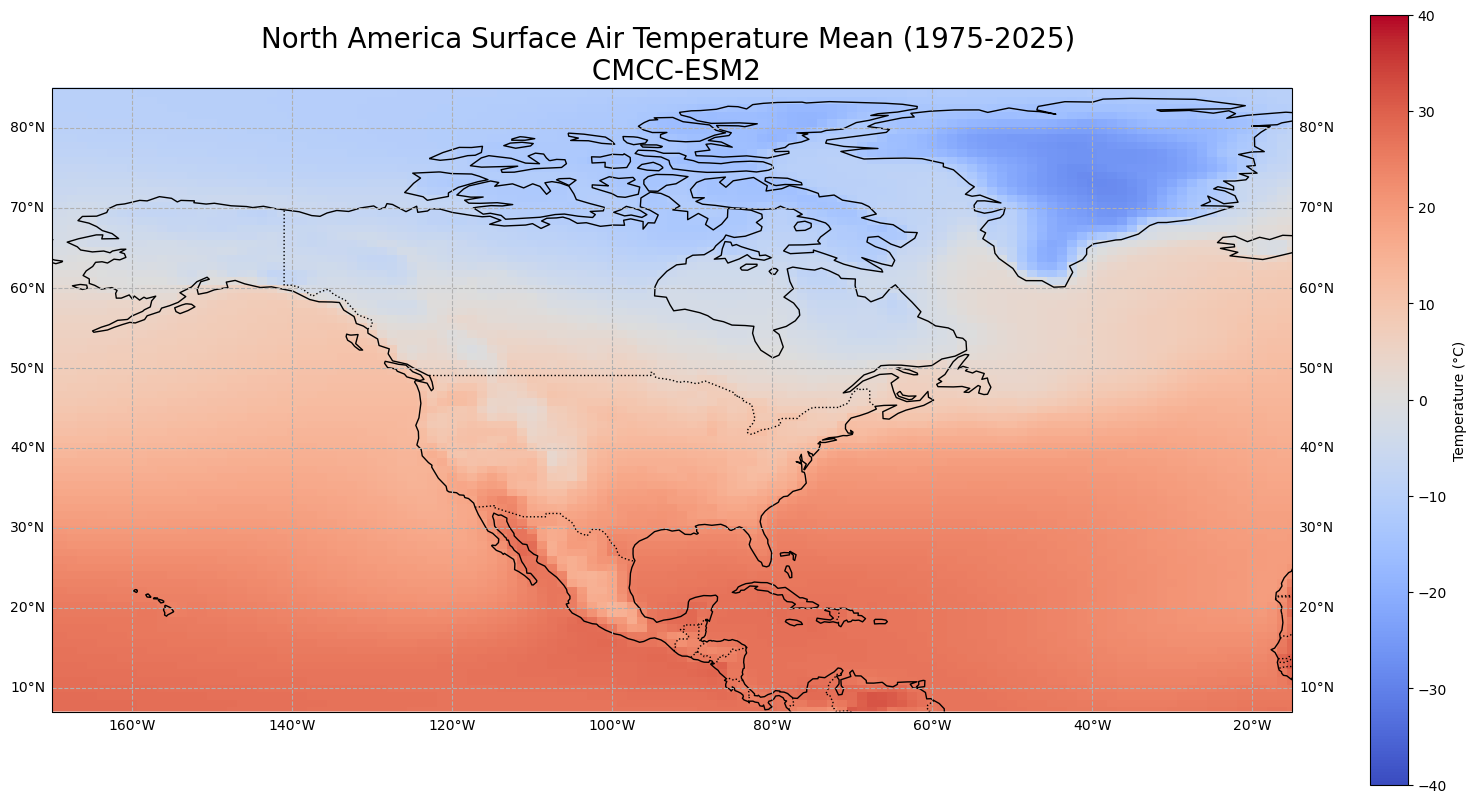

In [8]:
##### CMCC-ESM2 1975-2025 #####

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), 
                       subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(cmcc_early_annmn.lon, 
                     cmcc_early_annmn.lat, 
                     cmcc_early_annmn["tas"], 
                     transform=map, 
                     cmap="coolwarm", 
                     vmin=-40, 
                     vmax=40)

# Set spatial extent of plot
ax.set_extent(region, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("North America Surface Air Temperature Mean (1975-2025) \n CMCC-ESM2", fontsize= 20)
plt.show()

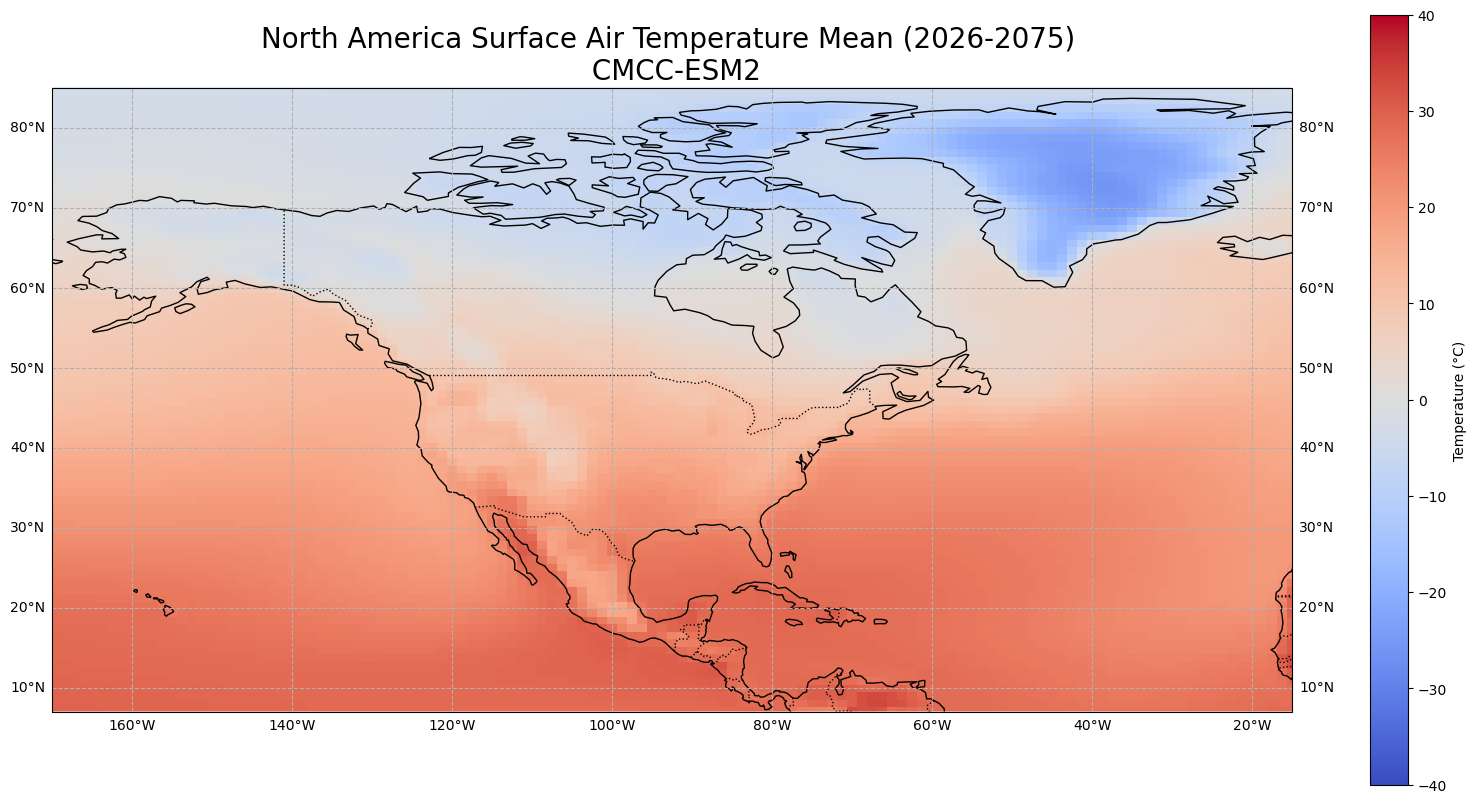

In [9]:
##### CMCC-ESM2 2026-2075 #####

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), 
                       subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(cmcc_late_annmn.lon, 
                     cmcc_late_annmn.lat, 
                     cmcc_late_annmn["tas"], 
                     transform=map, 
                     cmap="coolwarm", 
                     vmin=-40, 
                     vmax=40)

# Set spatial extent of plot
ax.set_extent(region, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("North America Surface Air Temperature Mean (2026-2075) \n CMCC-ESM2", fontsize= 20)
plt.show()

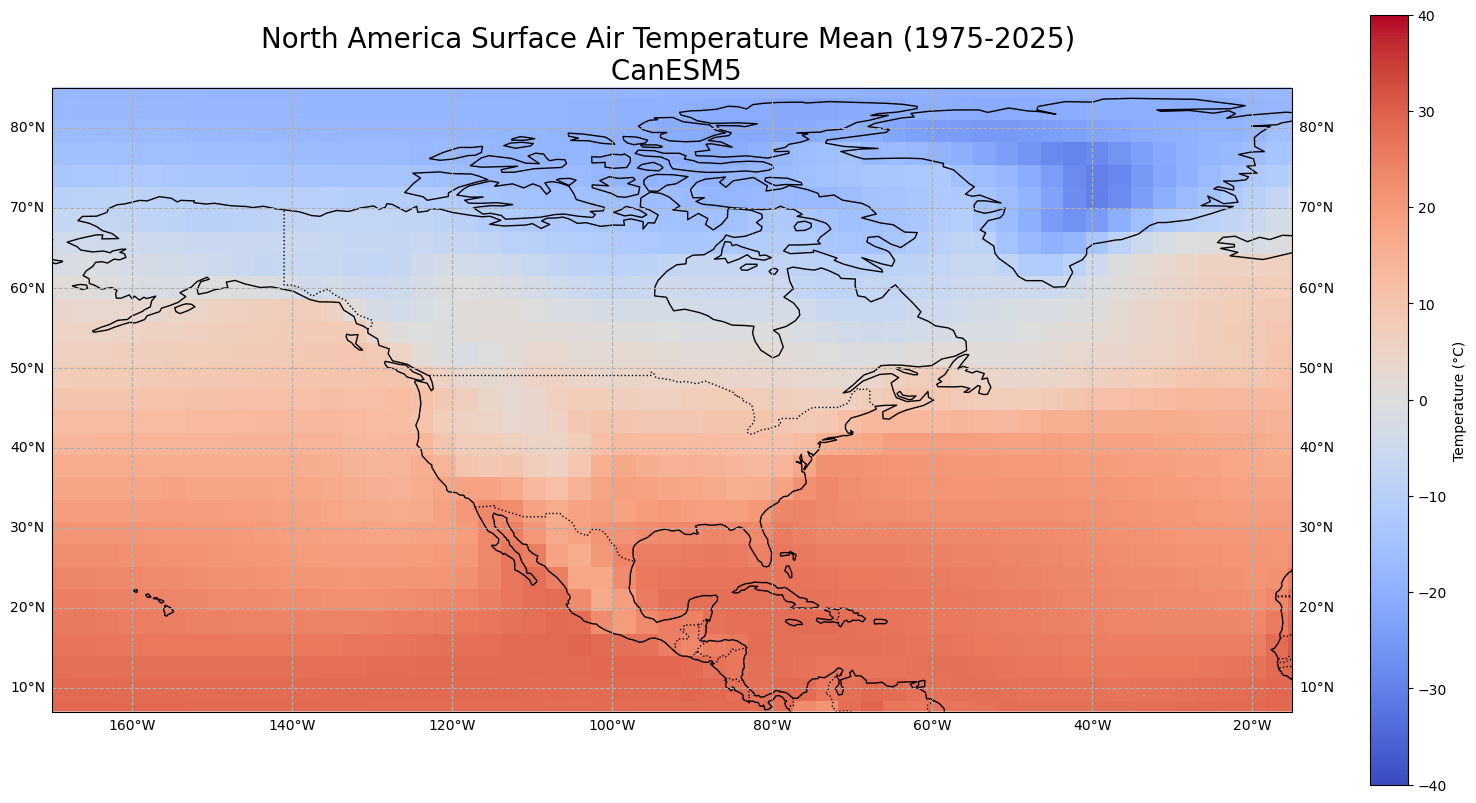

In [10]:
##### CanESM5 1975-2025 #####

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), 
                       subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(can_early_annmn.lon, 
                     can_early_annmn.lat, 
                     can_early_annmn["tas"], 
                     transform=map, 
                     cmap="coolwarm", 
                     vmin=-40, 
                     vmax=40)

# Set spatial extent of plot
ax.set_extent(region, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("North America Surface Air Temperature Mean (1975-2025) \n CanESM5", fontsize= 20)
plt.show()

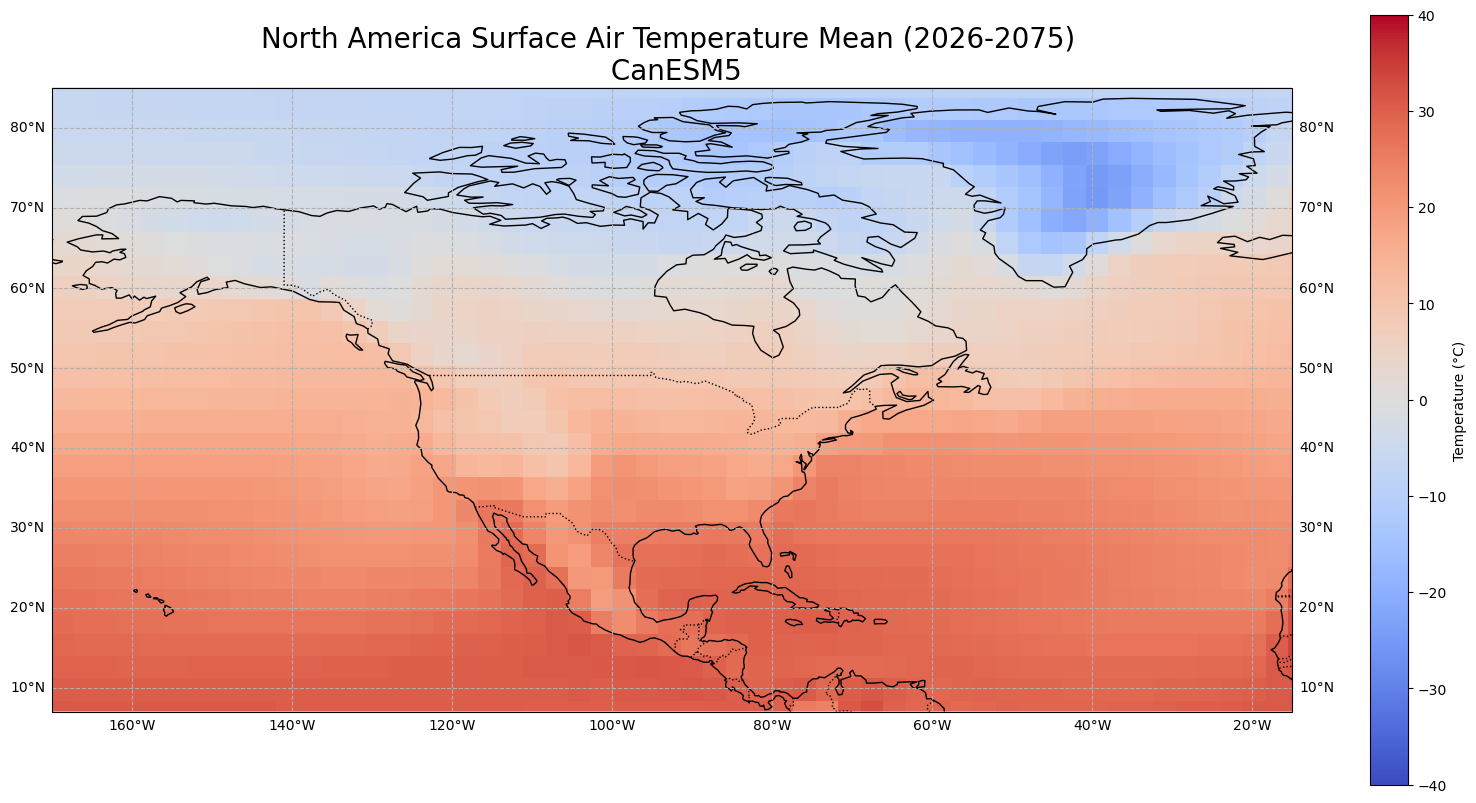

In [11]:
##### CanESM5 2026-2075 #####

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), 
                       subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(can_late_annmn.lon, 
                     can_late_annmn.lat, 
                     can_late_annmn["tas"], 
                     transform=map, 
                     cmap="coolwarm", 
                     vmin=-40, 
                     vmax=40)

# Set spatial extent of plot
ax.set_extent(region, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("North America Surface Air Temperature Mean (2026-2075) \n CanESM5", fontsize= 20)
plt.show()

## Map Difference in Averages

Now, I will plot the difference in the averages between the two time periods for both models.

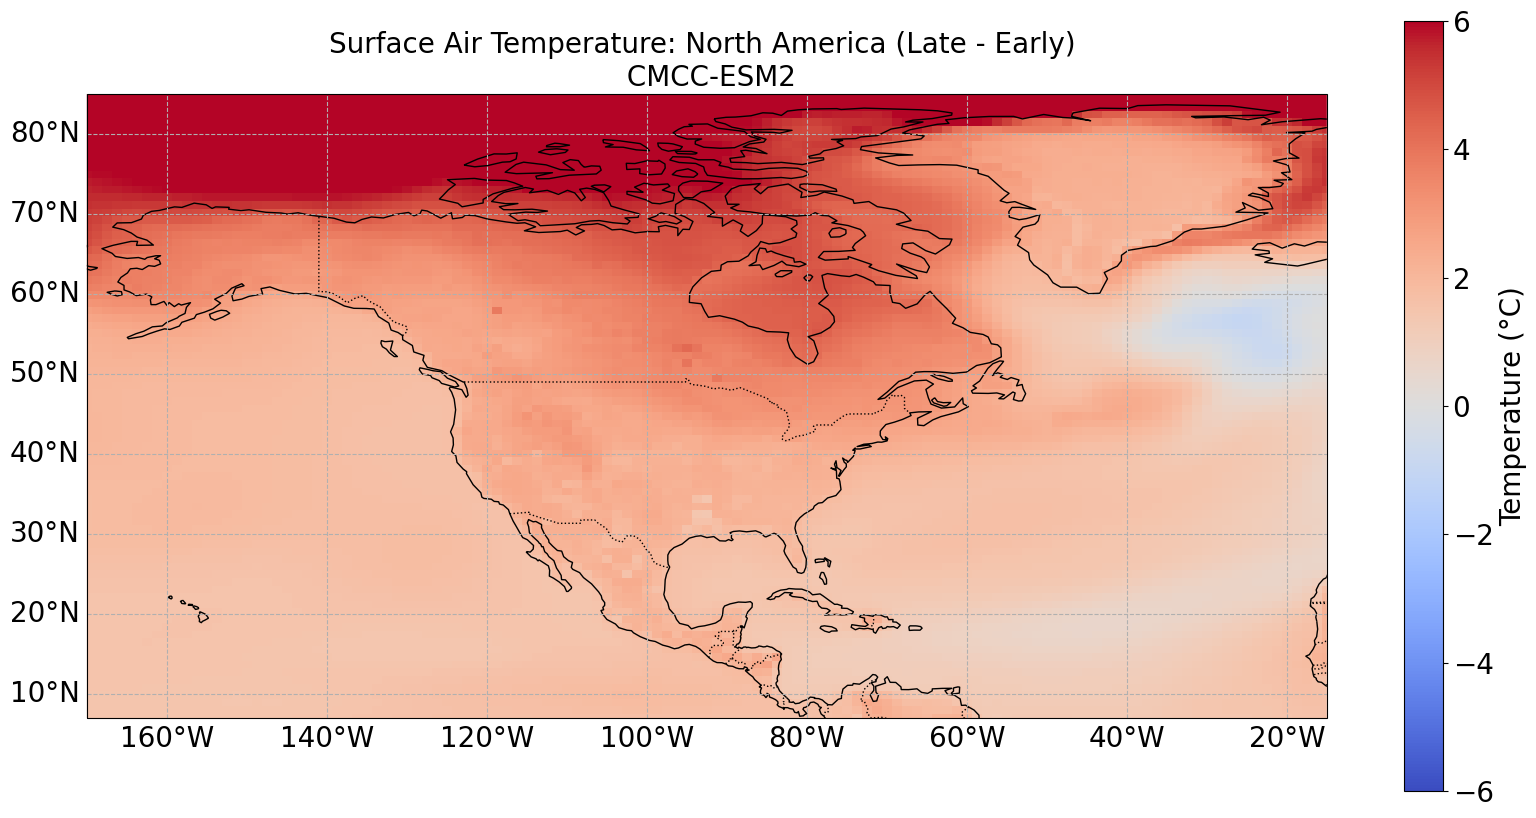

In [12]:
##### CMCC-ESM2 #####

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), 
                       subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(cmcc_late_annmn.lon, 
                     cmcc_late_annmn.lat, 
                     cmcc_late_annmn.tas - cmcc_early_annmn.tas, 
                     transform=map, cmap="coolwarm", vmin=-6, vmax=6)

# Set spatial extent of plot
ax.set_extent(region, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)", fontsize=20)
cbar.ax.tick_params(labelsize=20)

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False
gl.right_labels = False

# Set font size for x, y-axis labels
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

# Add title, show plot
ax.set_title("Surface Air Temperature: North America (Late - Early) \n CMCC-ESM2", fontsize= 20)
plt.show()

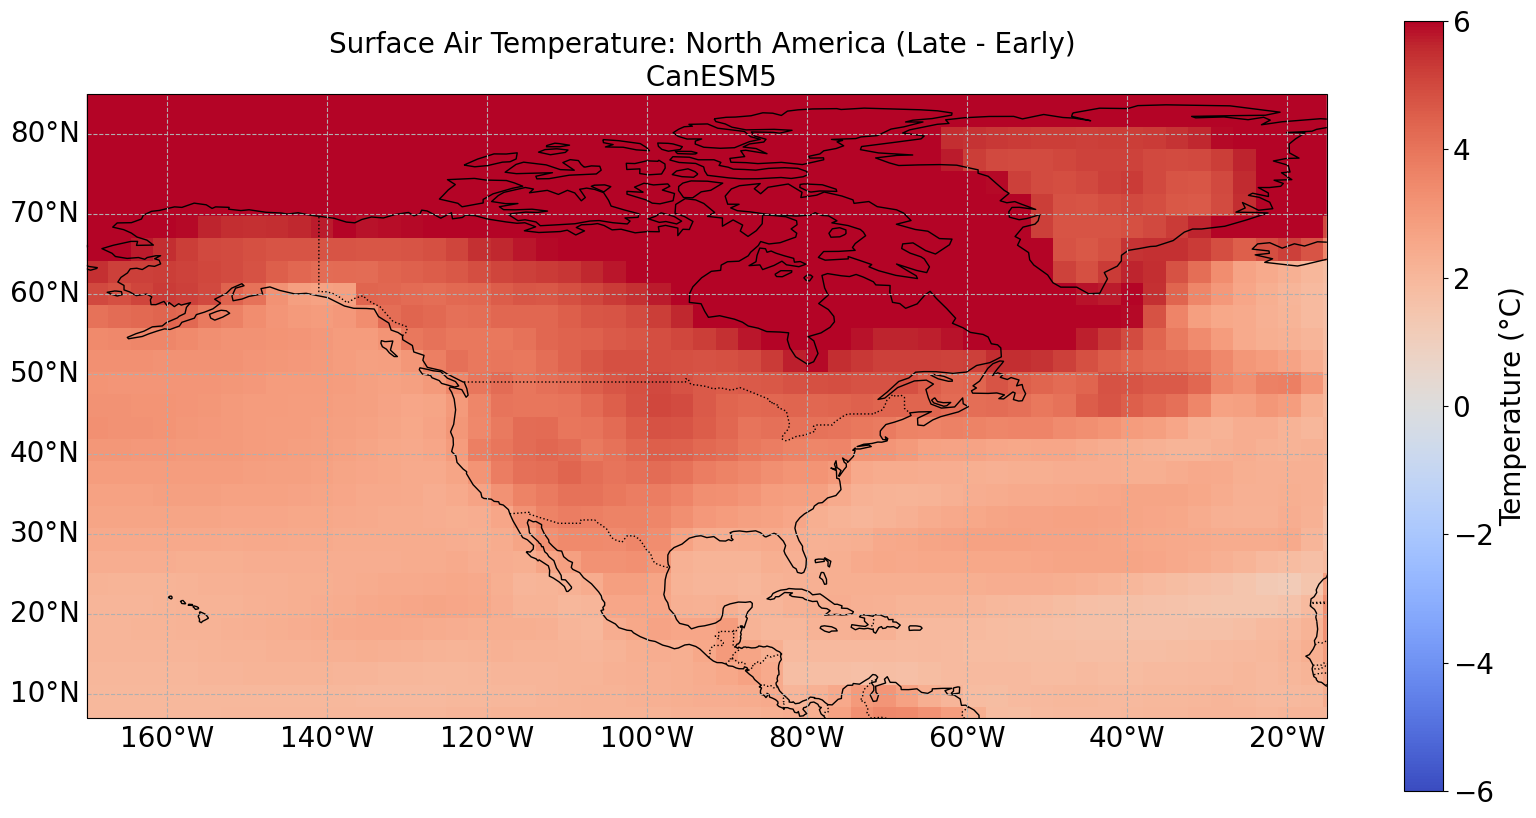

In [13]:
##### CanESM5 #####

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), 
                       subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(can_late_annmn.lon, 
                     can_late_annmn.lat, 
                     can_late_annmn.tas - can_early_annmn.tas, 
                     transform=map, cmap="coolwarm", vmin=-6, vmax=6)

# Set spatial extent of plot
ax.set_extent(region, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)", fontsize=20)
cbar.ax.tick_params(labelsize=20)

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False
gl.right_labels = False

# Set font size for x, y-axis labels
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

# Add title, show plot
ax.set_title("Surface Air Temperature: North America (Late - Early) \n CanESM5", fontsize= 20)
plt.show()

## Results & Discussion

Both models show a trend of warming over the 100-year time span, with the highest increases occurring closer to the pole. This supports the phenomenon of Arctic amplification, where the Arctic is warming approximately four times faster than the global average. (Rantanen et al). The Canadian Earth System Model projects a greater degree of warming compared to the CMCC Earth System Model, though it’s important to note that the CMCC model uses a finer spatial resolution. This increased resolution allows it to capture nuances that the coarser CanESM model may overlook, possibly contributing to the differences in the model projections.

This degree of warming predicted by the SSP585 projection would be devestating for ecosystems and people in North America, with temperature increases ranging from 4 to 6 degrees compared to 1975 levels. Climate change effects that are already being experienced are likely to be intensified and the impacts may include more extreme and frequent weather events, accelerated ice melt and sea level rise, increased risks of drought and wildfire, and significant stress on water and food systems. These models emphasize the urgency of global mitigation and adaptation planning in order to slow warming and reduce vulnerability in a rapidly changing climate.

## Citation
[1]: Rantanen, M., Karpechko, A.Y., Lipponen, A. et al. The Arctic has warmed nearly four times faster than the globe since 1979. Commun Earth Environ 3, 168 (2022). https://doi.org/10.1038/s43247-022-00498-3